<a href="https://colab.research.google.com/github/UlyShel/basics_of_machine_learning/blob/main/HW6_Ulyana_Shelegova.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Интеллектуальный анализ данных – весна 2024
# Домашнее задание 6: классификация текстов

Правила:



*   Домашнее задание оценивается в 10 баллов.
*   Можно использовать без доказательства любые результаты, встречавшиеся на лекциях или семинарах по курсу, если получение этих результатов не является вопросом задания.
*  Можно использовать любые свободные источники с *обязательным* указанием ссылки на них.
*  Плагиат не допускается. При обнаружении случаев списывания, 0 за работу выставляется всем участникам нарушения, даже если можно установить, кто у кого списал.
*  Старайтесь сделать код как можно более оптимальным. В частности, будет штрафоваться использование циклов в тех случаях, когда операцию можно совершить при помощи инструментов библиотек, о которых рассказывалось в курсе.

В этом домашнем задании вам предстоит построить классификатор текстов.

Будем предсказывать эмоциональную окраску твиттов о коронавирусе.



In [ ]:
import numpy as np
import pandas as pd
from typing import  List
import matplotlib.pyplot as plt
import seaborn as sns
from string import punctuation

In [ ]:
!wget https://raw.githubusercontent.com/hse-ds/iad-intro-ds/master/2024/homeworks/hw06_texts/tweets_coronavirus.csv

--2024-05-13 12:06:39--  https://raw.githubusercontent.com/hse-ds/iad-intro-ds/master/2024/homeworks/hw06_texts/tweets_coronavirus.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.108.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 8829280 (8.4M) [text/plain]
Saving to: ‘tweets_coronavirus.csv’

tweets_coronavirus. 100%[===================>]   8.42M  --.-KB/s    in 0.1s    

2024-05-13 12:06:40 (58.8 MB/s) - ‘tweets_coronavirus.csv’ saved [8829280/8829280]



In [ ]:
df = pd.read_csv('/content/tweets_coronavirus.csv', encoding='latin-1')
df.sample(4)

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment
17573,25168,70120,"Trumbull, CT and Orlando, FL",25-03-2020,COVID-19 Consumer Warnings and Safety Tips fro...,Positive
18079,25799,70751,NaN,25-03-2020,The long road to the supermarket when shelves ...,Extremely Negative
21471,29995,74947,London England UK,02-04-2020,At first I thought the fact that Corona beer w...,Positive
32747,44079,89031,"Washington, DC",13-04-2020,A look at changes in search behavior and what ...,Extremely Positive


Для каждого твитта указано:


*   UserName - имя пользователя, заменено на целое число для анонимности
*   ScreenName - отображающееся имя пользователя, заменено на целое число для анонимности
*   Location - местоположение
*   TweetAt - дата создания твитта
*   OriginalTweet - текст твитта
*   Sentiment - эмоциональная окраска твитта (целевая переменная)



## Задание 1 Подготовка (0.5 балла)

Целевая переменная находится в колонке `Sentiment`.  Преобразуйте ее таким образом, чтобы она стала бинарной: 1 - если у твитта положительная эмоциональная окраска и 0 - если отрицательная.

In [ ]:
set(df['Sentiment'])

{'Extremely Negative', 'Extremely Positive', 'Negative', 'Positive'}

In [ ]:
X = df.drop('Sentiment', axis=1)
y = (df['Sentiment'].isin(['Positive', 'Extremely Positive'])).astype(int)

Сбалансированы ли классы?

In [ ]:
y.value_counts()

Sentiment
1    18046
0    15398
Name: count, dtype: int64

**Ответ:** Баланс классов не идеальный, но вполне приемлимый: примерно 53% положительных твиттов и 46% отрицательных.

Выведете на экран информацию о пропусках в данных. Если пропуски присутствуют заполните их строкой 'Unknown'.

In [ ]:
X.isna().any()

UserName         False
ScreenName       False
Location          True
TweetAt          False
OriginalTweet    False
dtype: bool

Пропуски только в стобце Location, это категориальный признак

In [ ]:
X_filled = X.fillna('Unknown')
X_filled

,UserName,ScreenName,Location,TweetAt,OriginalTweet
0,3800,48752,UK,16-03-2020,advice Talk to your neighbours family to excha...
1,3801,48753,Vagabonds,16-03-2020,Coronavirus Australia: Woolworths to give elde...
2,3802,48754,Unknown,16-03-2020,My food stock is not the only one which is emp...
3,3803,48755,Unknown,16-03-2020,"Me, ready to go at supermarket during the #COV..."
4,3804,48756,"ÃÂT: 36.319708,-82.363649",16-03-2020,As news of the regionÃÂs first confirmed COV...
...,...,...,...,...,...
33439,44949,89901,OHIO,14-04-2020,I never that weÃÂd be in a situation &amp; w...
33440,44950,89902,Unknown,14-04-2020,@MrSilverScott you are definitely my man. I fe...
33441,44952,89904,Unknown,14-04-2020,Response to complaint not provided citing COVI...
33442,44953,89905,Unknown,14-04-2020,You know itÃÂs getting tough when @KameronWi...


In [ ]:
X_y = pd.concat([X_filled, y], axis=1)

Разделите данные на обучающие и тестовые в соотношении 7 : 3 и `random_state=0`

In [ ]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(X_y, test_size = 0.3, random_state=0)

## Задание 2 Токенизация (3 балла)

Постройте словарь на основе обучающей выборки и посчитайте количество встреч каждого токена с использованием самой простой токенизации - деления текстов по пробельным символам и приведение токенов в нижний регистр

In [ ]:
import nltk
from nltk.tokenize import word_tokenize
from collections import Counter

In [ ]:
tweets_list = train['OriginalTweet'].tolist()
tweets = [x.lower() for x in tweets_list]

In [ ]:
merged_text = ' '.join(tweets)

In [ ]:
counted_words = Counter(merged_text.split())
counted_words

Counter({'why': 654,
         'we': 3787,
         'still': 763,
         'want': 487,
         'to': 23373,
         'buy': 748,
         'so': 1837,
         'much': 482,
         'stuff': 106,
         'during': 1908,
         'quarantine': 154,
         'https://t.co/1m881cwfuv': 1,
         '#shopping': 121,
         '#covid_19': 1660,
         '#online': 40,
         'with': 4063,
         'driving': 77,
         'even': 682,
         'more': 2008,
         'usage': 22,
         'a': 11737,
         'strong': 93,
         'strategy': 33,
         'is': 7383,
         'critical': 156,
         'now': 1349,
         'then': 435,
         'ever': 179,
         'luckily': 8,
         'and': 14684,
         'april': 163,
         '16': 36,
         'webinar': 65,
         'will': 2726,
         'dive': 10,
         'into': 666,
         'growing': 84,
         'app': 52,
         'awareness': 32,
         'targeting': 9,
         'high': 408,
         'lifetime': 4,
         'value': 

Какой размер словаря получился?

In [ ]:
f'Размер словаря: {len(counted_words.keys())}'

'Размер словаря: 79755'

Выведите 10 самых популярных токенов с количеством встреч каждого из них. Объясните, почему именно эти токены в топе

In [ ]:
most_popular_tokens = pd.DataFrame(sorted(counted_words.items(), key=lambda x: x[1], reverse=True)[:10], columns=['word', 'frequency'])
most_popular_tokens

,word,frequency
0,the,26815
1,to,23373
2,and,14684
3,of,13012
4,a,11737
5,in,11198
6,for,8566
7,#coronavirus,8223
8,is,7383
9,are,7050


**Ответ:** Большинство из этих слов (за исключением хэштега коронавирус) являюстя стоп-словами, то есть общеупотребительными для языка (местоимения, предлоги и тд), которые будут встречаться в любых текстах в больших количествах. Они не несут никакой смысловой нагрузки в процессе анализа текстов, выявления основной мысли, а потому их необходимо удалить


Удалите стоп-слова из словаря и выведите новый топ-10 токенов (и количество встреч) по популярности.  Что можно сказать  о нем?

In [ ]:
nltk.download("stopwords", quiet=True)

True

In [ ]:
from nltk.corpus import stopwords

In [ ]:
stop_words = set(stopwords.words('english'))

In [ ]:
no_stop_words = {k: v for k,v in counted_words.items() if k not in stop_words}

In [ ]:
popular_no_stop_words = pd.DataFrame(sorted(no_stop_words.items(), key=lambda x: x[1], reverse=True), columns=['word', 'frequency'])[:10]
popular_no_stop_words

,word,frequency
0,#coronavirus,8223
1,prices,3891
2,food,3820
3,grocery,3469
4,supermarket,3288
5,people,3175
6,covid-19,3173
7,store,3155
8,#covid19,2471
9,&amp;,2314


**Ответ:**  наконец самые популярные слова имеют прямое отношение к теме. Учитывая то, что мы анализируем твитты про коронавирус, логично, что хэштег коронавирус будет встречаться в большинстве из них. Судя по остальным токенам, люди наиболее озабочены кризисной ситуацией, ростом цен, закрытием магазинов, поэтому слова 'food', 'prices', 'store', 'grocery' и др. настолько распространены.

Также выведите 20 самых непопулярных слов (если самых непопулярных слов больше выведите любые 20 из них) Почему эти токены непопулярны, требуется ли как-то дополнительно работать с ними?

In [ ]:
not_popular_no_stop_words = pd.DataFrame(sorted(no_stop_words.items(), key=lambda x: x[1])[:20], columns=['word', 'frequency'])
not_popular_no_stop_words

,word,frequency
0,https://t.co/1m881cwfuv,1
1,happy..,1
2,https://t.co/z0intks34x,1
3,mnuchinãâs,1
4,brink.,1
5,https://t.co/jmobv8z0u0,1
6,university's,1
7,teaching.),1
8,@catholicpres,1
9,@catholicuniv,1


**Ответ:** большинство из них - какие-то локальные хэштеги, ответы пользователям. Есть и ссылки. В целом, такие токены стоит удалить, потому что они не несут особой смысловой нагрузки. Хотя хэштеги иногда могут быть полезны и презентовать эмоциональное отношение пользователя, но обычно они сопровождаются полноценными твиттами, в которых уже и так описано отношение человека к исследуемой ситуации.



Теперь воспользуемся токенайзером получше - TweetTokenizer из библиотеки nltk. Примените его и посмотрите на топ-10 популярных слов. Чем он отличается от топа, который получался раньше? Почему?

In [ ]:
from nltk.tokenize import TweetTokenizer

tweet_tokenizer = TweetTokenizer()
tweet_tokenized = tweet_tokenizer.tokenize(merged_text)

In [ ]:
counted_tweets = dict(Counter(tweet_tokenized))
data_tweets = pd.DataFrame(sorted(counted_tweets.items(), key=lambda x: x[1], reverse=True), columns=['token', 'frequency'])[:10]
data_tweets

,token,frequency
0,the,26993
1,.,24108
2,to,23478
3,",",17571
4,and,14825
5,of,13044
6,a,11891
7,in,11348
8,?,9524
9,#coronavirus,8808


**Ответ:** получается не очень красиво, потому что TweetTokenizer сохраняет смайлики и пунктуацию отдельно, что не всегда удобно.. Хотя смайлики могут помочь проанализировать окраску текста, но пунктуцию стоит убрать наравне со стоп-словами, потому что иначе выходит не информативно. Единственный токен, напрямую связанный с темой - хэштег коронавирус, но здесь он последний из часто встречающихся, что не очень хороший признак!!!

Удалите из словаря стоп-слова и пунктуацию, посмотрите на новый топ-10 слов с количеством встреч, есть ли теперь в нем что-то не похожее на слова?

In [ ]:
from string import punctuation

no_stop_words_tweets = {k: v for k,v in counted_tweets.items() if k not in set(punctuation).union(stop_words)}

In [ ]:
data_tweets_2 = pd.DataFrame(sorted(no_stop_words_tweets.items(), key=lambda x: x[1], reverse=True), columns=['token', 'frequency'])[:10]
data_tweets_2

,token,frequency
0,#coronavirus,8808
1,â,7415
2,,7311
3,19,7167
4,covid,6253
5,prices,4601
6,,4372
7,food,4367
8,store,3877
9,supermarket,3805


**Ответ:** оставлись буквы на других языках (не на английском) , остались цифры и квадратики (это, предположительно, бывшие смайлики).
Таким образом, стоит загразить stop words на испанском и добавить цифры в стоп_вордс.

Удалите из словаря токены из одного символа, с позицией в таблице Unicode 128 и более (`ord(x) >= 128`)

Выведите топ-10 самых популярных и топ-20 непопулярных слов. Чем полученные топы отличаются от итоговых топов, полученных при использовании токенизации по пробелам? Что теперь лучше, а что хуже?

In [ ]:
no_stop_words_other = {k: v for k,v in no_stop_words_tweets.items() if len(k) > 1 or ord(k) < 128}
data_tweets_3 = pd.DataFrame(sorted(no_stop_words_other.items(), key=lambda x: x[1], reverse=True), columns=['token', 'frequency'])[:10]
data_tweets_3

,token,frequency
0,#coronavirus,8808
1,19,7167
2,covid,6253
3,prices,4601
4,food,4367
5,store,3877
6,supermarket,3805
7,grocery,3523
8,people,3463
9,#covid19,2589


In [ ]:
data_tweets_3_reversed = pd.DataFrame(sorted(no_stop_words_other.items(), key=lambda x: x[1]), columns=['token', 'frequency'])[:20]
data_tweets_3_reversed

,token,frequency
0,https://t.co/1m881cwfuv,1
1,https://t.co/z0intks34x,1
2,mnuchinã,1
3,https://t.co/jmobv8z0u0,1
4,university's,1
5,@catholicpres,1
6,@catholicuniv,1
7,https://t.co/evqby035wf,1
8,https://t.co/riqrhxxeim,1
9,@ballardspahrll,1


**Ответ:** теперь мы четко видим те токены, которые наиболее часто встречаются, больше нет нечитаемых символов (смайликов) и букв из других языков. Тем не менее, пролема появления чисел так же присутствует, потому что с помощью этого способа мы убираем лишь цифры. Таким образом, в общем и целом лучше, чем было при первой, самой простой токенизации не стало, хотя жизнь себе усложнили..

Наименее популярные все так же упоминания рандомных юзеров, странные хэштеги и различные ссылки.

Выведите топ-10 популярных хештегов с количеством встреч. Что можно сказать о них?

In [ ]:
hashtags = {k:v for k, v in no_stop_words_other.items() if k[0] == '#'}
hashtags_df = pd.DataFrame(sorted(hashtags.items(), key=lambda x: x[1], reverse=True), columns=['hastag', 'frequency'])[:10]
hashtags_df

,hastag,frequency
0,#coronavirus,8808
1,#covid19,2589
2,#covid_19,1734
3,#covid2019,946
4,#toiletpaper,744
5,#covid,641
6,#socialdistancing,465
7,#coronacrisis,448
8,#pandemic,257
9,#coronaviruspandemic,249


**Ответ:** среди самых популяных, конечно, в основном хэштеги с простым упоминанием коронавируса, что имеет нейтральную эмоциональную окраску. Существуют так же и упоминания кризиса, туалетной бумаги, что может свидетельствовать о том, что хэштеги все-таки в основном негативную окраску носят.

То же самое проделайте для ссылок на сайт https://t.co Сравнима ли популярность ссылок с популярностью хештегов? Будет ли информация о ссылке на конкретную страницу полезна?

In [ ]:
website = {k:v for k, v in no_stop_words_other.items() if k[:len('https://t.co')] == 'https://t.co'}
websites_df = pd.DataFrame(sorted(website.items(), key=lambda x: x[1], reverse=True), columns=['website', 'frequency'])[:10]
websites_df

,website,frequency
0,https://t.co/oxa7swtond,5
1,https://t.co/gp3eusapl8,4
2,https://t.co/deftrui1pfãâ,3
3,https://t.co/wrlhyzizaa,3
4,https://t.co/kuwipf1kqw,3
5,https://t.co/zjnrx6dkkn,3
6,https://t.co/3gbbdpdjat,3
7,https://t.co/e2znxajpre,3
8,https://t.co/catkegayoy,3
9,https://t.co/g63rp042ho,3


**Ответ:** абсолютно не сравнима (самый популярный хэштеги встречается почти 9к раз, самая популярная ссылка - 6). Если хэштеги в основном используются для навигации и привлечения внимания к собственной публикации, то использование ссылок необходимо для распространения чужой, и то такой способ распространения выбирается пользователями в очень редких случаях. Исходя из этого, можно сказать, что ссылки можно спокойно убрать, из них не вытащишь особой стастистики

Используем опыт предыдущих экспериментов и напишем собственный токенайзер, улучшив TweetTokenizer. Функция tokenize должна:



*   Привести текст в нижний регистр
*   Применить TweetTokenizer для изначального выделения токенов
*   Удалить стоп-слова, пунктуацию, токены из одного символа, с позицией в таблице Unicode 128 и более и ссылки на t.co



In [ ]:
def custom_tokenizer(text):

  text = text.lower()

  tweet_tokenizer = TweetTokenizer()
  text_tokenized = tweet_tokenizer.tokenize(text)

  stop_words = set(stopwords.words('english'))

  tokens = [x for x in text_tokenized if ((len(x) > 1 or ord(x) < 128) and x not in set(punctuation).union(stop_words)) and x[:len('https://t.co')] != 'https://t.co']

  return tokens


In [ ]:
custom_tokenizer('This is sample text!!!! @Sample_text I, \x92\x92 https://t.co/sample  #sampletext')

['sample', 'text', '@sample_text', '#sampletext']

## Задание 3 Векторизация текстов (2 балла)

Обучите CountVectorizer с использованием custom_tokenizer в качестве токенайзера. Как размер полученного словаря соотносится с размером изначального словаря из начала задания 2?

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer

cv = CountVectorizer(tokenizer=custom_tokenizer)
tokenized_vectorized_fit = cv.fit(train['OriginalTweet'])

print(len(cv.vocabulary_))

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


45308


**Ответ:** размер словаря уменьшился в два раза, что, конечно, связано с тем, что мы сделали не самую очевидную токенизацию сплитом, а поработали над "лишними словами" и не учли ссылки, что помогло учесть лишь самые важные слова :)

Посмотрим на какой-нибудь конкретный твитт:

In [ ]:
ind = 9023
train.iloc[ind]['OriginalTweet'], train.iloc[ind]['Sentiment']

('Nice one @SkyNews lets not panic but show ppl in france queueing for food!!! #CoronavirusOutbreak #COVID2019 brainless!! Ffs',
 0)

Автор твитта не доволен ситуацией с едой во Франции и текст имеет резко негативную окраску.

Примените обученный CountVectorizer для векторизации данного текста, и попытайтесь определить самый важный токен и самый неважный токен (токен, компонента которого в векторе максимальна/минимальна, без учета 0). Хорошо ли они определились, почему?

In [ ]:
france_vectorized = cv.transform([train.iloc[ind]['OriginalTweet']])

In [ ]:
names_france = cv.get_feature_names_out()

In [ ]:
max_index = france_vectorized.toarray().argmax()
min_index = france_vectorized.toarray().nonzero()[0].argmin()

most_important_token = names_france[max_index]
least_important_token = names_france[min_index]

In [ ]:
most_important_token, least_important_token

('#coronavirusoutbreak', '###covid-19')

**Ответ:** определились плоховато.. во-первых, по какой-то причине выделился токен, который даже не встречается в исходном твитте, и то лишь потому что, как мы видим ниже, он идет первым в дата фрейме. "Важный" токен на самом деле не особо важен, потому что так же определился, как первое слово из дата фрейма, которое встретилось под самой большой компонентной, равной еданице (а все слова встречаются лишь по одному разу!) и, более того, неудачно! Хэштег coronavirusoutbreak никак не характеризует отношение человека, а лишь указывает на то, что твит о короноварисусе, что мы и сами знаем..

In [ ]:
pd.DataFrame(france_vectorized.toarray(), columns=cv.get_feature_names_out())

,###covid-19,##coronavirus,##covid_19,##fda,##stayhomesavelives,#01,#10,#1000,#100daysofcode,#100percent,...,zumindest,zuppardo's,zur,zuschlã,zusendung,zwd,zwoferink,zzz,zã,âºper
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Теперь примените TfidfVectorizer и  определите самый важный/неважный токены. Хорошо ли определились, почему?

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf_vec = TfidfVectorizer(tokenizer=custom_tokenizer)

In [ ]:
tfidf_vec.fit(train['OriginalTweet'])

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


TfidfVectorizer(tokenizer=<function custom_tokenizer at 0x7f76fe3b4670>)

In [ ]:
france_tfidf = tfidf_vec.transform([train.iloc[ind]['OriginalTweet']])

In [ ]:
names_france_tfidf = tfidf_vec.get_feature_names_out()
max_index_2 = france_tfidf.toarray().argmax()
min_index_2 = france_tfidf.toarray().nonzero()[0].argmin()

most_important_token_2 = names_france_tfidf[max_index_2]
least_important_token_2  = names_france_tfidf[min_index_2]

most_important_token_2, least_important_token_2

('brainless', '###covid-19')

**Ответ:** самый важный токен определился отлично, как раз четко репрезентует негавтиную окраску твита! Это произошло потому, что в отличие от мешка слов tf-idf как кодировка отражает реальные веса слова. Мы понижаем важность слов, которые встречаются часто (так, например, #coronavirusoutbreak очевидно встречается частенько, и я это даже проверю ниже), а вот слово brainless, вероятсно, не так популярно, и реально отражает уникальность этого конкретного твита

In [ ]:
tfidf_vec.vocabulary_['#coronavirusoutbreak']

1833

In [ ]:
tfidf_vec.vocabulary_['brainless']

20553

In [ ]:
tfidf_vec.vocabulary_['###covid-19']

0

Тут мы четко видим, насколько больше вес у brainless в сравнении с #coronavirusoutbreak! А у '###covid-19' вес совсем нулевой..

Найдите какой-нибудь положительно окрашенный твитт, где TfidfVectorizer хорошо (полезно для определения окраски) выделяет важный токен, поясните пример.

*Подсказка:* явно положительные твитты можно искать при помощи положительных слов (good, great, amazing и т. д.)

In [ ]:
train[train['OriginalTweet'].apply(lambda x: 'great' in x) & (train['Sentiment'] == 1)].tail(10)

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment
15708,22900,67852,New York City,24-03-2020,New lower prices on Cornet EMF meters is a gre...,1
10345,16354,61306,Calgary Alberta Canada,21-03-2020,"@kinsellawarren In the wealthier urban areas, ...",1
19574,27631,72583,"Washington, DC",26-03-2020,Our great Oil &amp; Gas industry is under unde...,1
12393,18825,63777,"Melbourne, Australia",22-03-2020,"@michaelfowler08 @theage Hey Michael, Ive just...",1
20462,28767,73719,"Glasgow, Scotland",28-03-2020,Combined my two great passions: camp Gilbert a...,1
21960,30608,75560,Unknown,02-04-2020,@dino_melaye I commend your efforts so far in ...,1
23905,33018,77970,Unknown,05-04-2020,Absolutely brilliant idea amp a great use of a...,1
25907,35528,80480,Bay Area,07-04-2020,Afraid of tracking in the #coronavirus? Here a...,1
18987,26911,71863,Unknown,25-03-2020,@AmyPoythress I hope you &amp; your family rem...,1
15620,22797,67749,Unknown,24-03-2020,The markets aren t collapsing bc of democrats ...,1


In [ ]:
train.loc[21883]['OriginalTweet'] #возьмем этот

"Coronavirus career pivots: 'I now work in a supermarket' great story. Make yourself useful #coronavirus #COVID19 #hope2020 https://t.co/KEn8gE7i4k"

In [ ]:
good_tfidf = tfidf_vec.transform([train.loc[21883]['OriginalTweet']])

good_max_index = good_tfidf.toarray().argmax()

names_france_tfidf[good_max_index]

'#hope2020'

В данном случае сразу видна положительная окраска, ведь автор очевидно рассчитывает на позитивный исход текущей ситуации, а слово "надежда" (скорее всего) не стало бы использоваться в негативном ключе. Возможно, твиты, где фигурирует это слово, можно проверить на окраску, чтобы убедиться в предположении!

In [ ]:
train_hope = train[train['OriginalTweet'].str.contains('hope|#hope')] # https://pandas.pydata.org/docs/reference/api/pandas.Series.str.contains.html

train_hope['Sentiment'].value_counts() #ну я пыталась..

Sentiment
1    213
0     79
Name: count, dtype: int64

Плохо получается с твитами, где используются сокращения, бессмысленные хэштеги по типу "#hashtag" (их тоже не мешало бы учитывать при токенизации, потому что они не только не несут никакой ценности, но и портят результат), или слова с опечатками. В этих случаях Tf-idf может не очень хорошо выделять важные токены.

In [ ]:
good_tfidf = tfidf_vec.transform([train.loc[15620]['OriginalTweet']])

good_max_index = good_tfidf.toarray().argmax()

names_france_tfidf[good_max_index]

'bc'

In [ ]:
good_tfidf = tfidf_vec.transform([train.loc[19574]['OriginalTweet']])

good_max_index = good_tfidf.toarray().argmax()

names_france_tfidf[good_max_index]

'seige'

In [ ]:
train.loc[19574]['OriginalTweet'] #вместо under siege

'Our great Oil &amp; Gas industry is under under seige after having one of the best years in recorded history. It will get better than ever as soon as our Country starts up again. Vital that it does for our National Security!'

## Задание 4 Обучение первых моделей (1 балл)

Примените оба векторайзера для получения матриц с признаками текстов.  Выделите целевую переменную.

In [ ]:
y_train = train['Sentiment']
X_train = train.drop('Sentiment', axis=1)

In [ ]:
y_test = test['Sentiment']
X_test = test.drop('Sentiment', axis=1)

In [ ]:
features_cv = cv.transform(X_train['OriginalTweet'])
features_cv_test= cv.transform(X_test['OriginalTweet'])

In [ ]:
features_tfidf = tfidf_vec.transform(X_train['OriginalTweet'])
features_tfidf_test = tfidf_vec.transform(X_test['OriginalTweet'])

In [ ]:
features_cv.toarray()

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [ ]:
features_tfidf.toarray()

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

Обучите логистическую регрессию на векторах из обоих векторайзеров. Посчитайте долю правильных ответов на обучающих и тестовых данных. Какой векторайзер показал лучший результат? Что можно сказать о моделях?

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

In [ ]:
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score

In [ ]:
lg = LogisticRegression(max_iter=200, random_state=42)
lg.fit(features_cv, y_train)

LogisticRegression(max_iter=200, random_state=42)

In [ ]:
print(classification_report(y_train, lg.predict(features_cv))) # accuracy - 0.98

              precision    recall  f1-score   support

           0       0.98      0.98      0.98     10846
           1       0.99      0.99      0.99     12564

    accuracy                           0.98     23410
   macro avg       0.98      0.98      0.98     23410
weighted avg       0.98      0.98      0.98     23410



In [ ]:
pred_test = lg.predict(features_cv_test)
print(classification_report(y_test, pred_test))  # accuracy - 0.87

              precision    recall  f1-score   support

           0       0.86      0.85      0.85      4552
           1       0.87      0.88      0.88      5482

    accuracy                           0.87     10034
   macro avg       0.87      0.87      0.87     10034
weighted avg       0.87      0.87      0.87     10034



In [ ]:
lg2 = LogisticRegression(max_iter=200, random_state=42)

In [ ]:
lg2.fit(features_tfidf, y_train)

LogisticRegression(max_iter=200, random_state=42)

In [ ]:
print(classification_report(y_train, lg2.predict(features_tfidf)))  # accuracy - 0.93

              precision    recall  f1-score   support

           0       0.93      0.91      0.92     10846
           1       0.92      0.94      0.93     12564

    accuracy                           0.93     23410
   macro avg       0.93      0.92      0.92     23410
weighted avg       0.93      0.93      0.93     23410



In [ ]:
print(classification_report(y_test, lg2.predict(features_tfidf_test)))  # accuracy - 0.85

              precision    recall  f1-score   support

           0       0.85      0.82      0.83      4552
           1       0.85      0.88      0.87      5482

    accuracy                           0.85     10034
   macro avg       0.85      0.85      0.85     10034
weighted avg       0.85      0.85      0.85     10034



**Ответ:** модель, где используется обычный мешок слов, справляется лучше, причем и на обучающей, и на тестовой выборке. Опять же, беря в расчет то, что мы делали раньше, 2 модель может справляться хуже, потому что уделяет слишком большое внимание редким словам, которые по факту могут быть просто неправильно написанными или добавленными для распространения твита (например как в случае с хэштегом hashtag). Но это, конечно, сложно проконтролировать и убрать..

## Задание 5 Стемминг (0.5 балла)

Для уменьшения словаря можно использовать стемминг.

Модифицируйте написанный токенайзер, добавив в него стемминг с использованием SnowballStemmer. Обучите Count- и Tfidf- векторайзеры. Как изменился размер словаря?

In [ ]:
from nltk.stem.snowball import SnowballStemmer

In [ ]:
def custom_stem_tokenizer(text):
  stemmer = SnowballStemmer("english")
  tokens = [stemmer.stem(x) for x in custom_tokenizer(text)]
  return tokens

In [ ]:
custom_stem_tokenizer('This is sample text!!!! @Sample_text I, \x92\x92 https://t.co/sample  #sampletext adding more words to check stemming')

['sampl', 'text', '@sample_text', '#sampletext', 'ad', 'word', 'check', 'stem']

In [ ]:
cv = CountVectorizer(tokenizer=custom_stem_tokenizer)

cv.fit(X_train['OriginalTweet'])

print(len(cv.vocabulary_))

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


36652


In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [ ]:
tfidf = TfidfVectorizer(tokenizer=custom_stem_tokenizer)
tfidf.fit(X_train['OriginalTweet'])
print(len(tfidf.vocabulary_))

36652


**Ответ** конечно, размер словаря уменьшился, потому что мы отбросили аффиксы , в последующем и в дата-сете будет меньше колонок, что, вероятно, позволит избежать переобучения.

Обучите логистическую регрессию с использованием обоих векторайзеров. Изменилось ли качество? Есть ли смысл применять стемминг?

In [ ]:
lg_cv = LogisticRegression(max_iter=200, random_state=42)

In [ ]:
y_test_cv = cv.transform(X_test['OriginalTweet'])

In [ ]:
lg_cv.fit(cv.transform(X_train['OriginalTweet']), y_train)
print(classification_report(y_test, lg_cv.predict(y_test_cv)))  # accuracy - 0.87

              precision    recall  f1-score   support

           0       0.86      0.84      0.85      4552
           1       0.87      0.89      0.88      5482

    accuracy                           0.87     10034
   macro avg       0.87      0.87      0.87     10034
weighted avg       0.87      0.87      0.87     10034



In [ ]:
y_test_tfidf = tfidf.transform(X_test['OriginalTweet'])

In [ ]:
lg_tfidf = LogisticRegression(max_iter=200, random_state=42)

In [ ]:
lg_tfidf.fit(tfidf.transform(X_train['OriginalTweet']), y_train)
print(classification_report(y_test, lg_tfidf.predict(y_test_tfidf)))  # accuracy - 0.86

              precision    recall  f1-score   support

           0       0.86      0.82      0.84      4552
           1       0.85      0.89      0.87      5482

    accuracy                           0.86     10034
   macro avg       0.86      0.85      0.85     10034
weighted avg       0.86      0.86      0.86     10034



**Ответ:** моментами качество даже упало, но в целом колебания настолько не существенны, что стемминг в данном случае можно и не применять

## Задание  6 Работа с частотами (1.5 балла)

Еще один способ уменьшить количество признаков - это использовать параметры min_df и max_df при построении векторайзера  эти параметры помогают ограничить требуемую частоту встречаемости токена в документах.

По умолчанию берутся все токены, которые встретились хотя бы один раз.



Подберите max_df такой, что размер словаря будет 36651 (на 1 меньше, чем было). Почему параметр получился такой большой/маленький?

По дефолту max_df = 1.0 ( https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html ), то есть, все токены, которые встречаются во всех документах, и проверить все варианты от исходного до max(cv.vocabulary_.values()) = 36651, потому что итерация по всем значениям в определенном диапазоне будет слишком длительной (я пыталась проверить хотя бы от 30000 до 36651 !!!), поэтому придется смотреть вручную.

Методом тыка было выяснено: max_df в диапазоне от (примерно) 10000 до 36651 выдает одинаковый размер словаря, то есть, 36652. А вот 5000 на удивление сразу существенно уменьшил длину до 36649.. Выбрала 8000, и вот...

In [ ]:
cv_df1 = CountVectorizer(tokenizer=custom_stem_tokenizer, max_df=8000)
cv_df1.fit(X_train['OriginalTweet']) #или max_df = 0.3
print(len(cv_df1.vocabulary_))

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


36651


In [ ]:
cv_df_test1 = cv_df1.transform(X_test['OriginalTweet'])

In [ ]:
lg_cv_df1 = LogisticRegression(max_iter=200, random_state=42)
lg_cv_df1.fit(cv_df1.transform(X_train['OriginalTweet']), y_train)

LogisticRegression(max_iter=200, random_state=42)

In [ ]:
print(classification_report(y_test, lg_cv_df1.predict(cv_df_test1)))  # accuracy - 0.87

              precision    recall  f1-score   support

           0       0.86      0.84      0.85      4552
           1       0.87      0.89      0.88      5482

    accuracy                           0.87     10034
   macro avg       0.87      0.87      0.87     10034
weighted avg       0.87      0.87      0.87     10034



In [ ]:
print({k:v for k,v in cv.vocabulary_.items() if k not in cv_df1.vocabulary_}) #тот самый токен, который мы убрали

{'#coronavirus': 1658}


**Ответ:** значение параметра max_df является относительно маленьким. Я предполагаю, что выбор именно такого параметра связан с нашим исходным дата сетом и проделанной обработкой (токенизация, очищение от стоп-слов, стемминг). Все это уже значительно упростило нам работу и избавило от шума, а потому ставить высокий порог нет смысла, мы уже выделили значимые слова, характеризирующие конкретные настроения. Но, ставя такое маленькое значение, у нас появляется возможность избавится от менее популярных токенов, которые мы, возможно, не сумели заметить, но они не несут смысловой нагрузки. Так, например, хэштег коронавирус, конечно, дает опредленную характеритстику твитов, с которыми мы работаем, но мы же и отбирали изначально те, которые имеют отношение именно к этой теме, а потому от данного токена мы можем спокойно избавиться!

Подберите min_df (используйте дефолтное значение max_df) в CountVectorizer таким образом, чтобы размер словаря был 3700 токенов (при использовании токенайзера со стеммингом), а качество осталось таким же, как и было. Что можно сказать о результатах?

In [ ]:
cv_df = CountVectorizer(tokenizer=custom_stem_tokenizer, min_df=11) # или min_df=0.00045
cv_df_train = cv_df.fit_transform(X_train['OriginalTweet'])
print(len(cv_df.vocabulary_))

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


3700


In [ ]:
cv_df_test = cv_df.transform(X_test['OriginalTweet'])

In [ ]:
lg_cv_df = LogisticRegression(max_iter=200, random_state=42)

In [ ]:
lg_cv_df.fit(cv_df.transform(X_train['OriginalTweet']), y_train)

LogisticRegression(max_iter=200, random_state=42)

In [ ]:
print(classification_report(y_test, lg_cv_df.predict(cv_df_test))) # accuracy - 0.87

              precision    recall  f1-score   support

           0       0.86      0.85      0.85      4552
           1       0.87      0.89      0.88      5482

    accuracy                           0.87     10034
   macro avg       0.87      0.87      0.87     10034
weighted avg       0.87      0.87      0.87     10034



**Ответ:** для того, чтобы размер словаря уменьшился до 3700, мы подобрали довольный маленький параметр min_df, что является мудрым решением в нашем случае опять же из-за того, что мы работаем с уже почищенным дата-сетом. Если подобрать сильно большой параметр, то мы либо получим пустой словарь, либо уменьшенный до совсем небольшого количества слов, что так же нехорошо, как иметь миллион признаков в дата сете. Учитывая то, что качество не поменялось (recall для негативных твитов даже чуть-чуть улучшился!), можно сказать, что эти преобразования и работа с max_df и min_df в нашем случае не помешает, потому что признаков стало ощутимо меньше, что ликвидировало и возможные проблемы переобучения, и памяти :)

В предыдущих заданиях признаки не скалировались. Отскалируйте данные (при словаре размера 3.7 тысяч, векторизованные CountVectorizer), обучите логистическую регрессию, посмотрите качество и выведите `berplot` содержащий по 10 токенов, с наибольшим по модулю положительными/отрицательными весами. Что можно сказать об этих токенах?

In [ ]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler(with_mean=False)
scaler.fit(cv_df_train.toarray())

StandardScaler(with_mean=False)

In [ ]:
scaler_train = scaler.transform(cv_df_train.toarray())

In [ ]:
scaler_test = scaler.transform(cv_df_test.toarray())

In [ ]:
lg_scaler = LogisticRegression(max_iter=200, random_state=42)

In [ ]:
lg_scaler.fit(scaler_train, y_train)

LogisticRegression(max_iter=200, random_state=42)

In [ ]:
print(classification_report(y_test, lg_scaler.predict(scaler_test))) # accuracy - 0.84

              precision    recall  f1-score   support

           0       0.83      0.82      0.83      4552
           1       0.85      0.86      0.86      5482

    accuracy                           0.84     10034
   macro avg       0.84      0.84      0.84     10034
weighted avg       0.84      0.84      0.84     10034



Точность и полнота немного упали

In [ ]:
feature_names_scaler = np.array(cv_df.get_feature_names_out())
scaler_df = pd.DataFrame({'token': feature_names_scaler.tolist(), 'weights': lg_scaler.coef_.reshape(-1)})

asc_tokens = scaler_df.sort_values(by='weights')[:10] #отрицательные веса

In [ ]:
desc_tokens = scaler_df.sort_values(by='weights')[-10:] #положительные

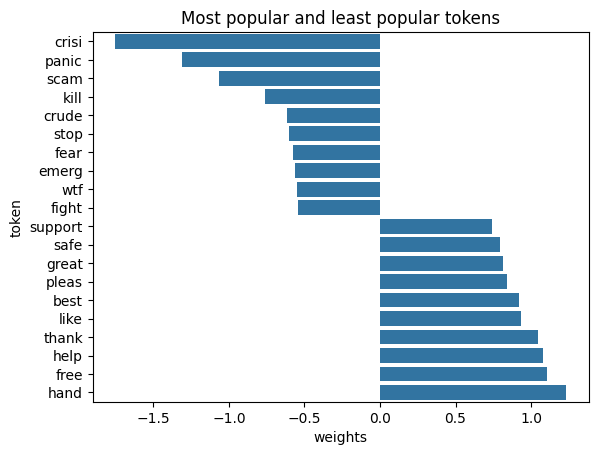

In [ ]:
data_tokens = pd.concat([asc_tokens, desc_tokens])
sns.barplot(data=data_tokens, x='weights', y='token')
plt.title('Most popular and least popular tokens');

**Ответ:** веса, а точнее их знаки, четко соотносятся с окраской твита, в котором эти токены могут быть использованы. Так, негативные слова, такие, как кризис, паника, убийства связаны с негативным отношением юзера, а поддержка, помощь и "хорошесть" - с позитивным.

## Задание 7 Другие признаки (1.5 балла)

Мы были сконцентрированы на работе с текстами твиттов и не использовали другие признаки - имена пользователя, дату и местоположение

Изучите признаки UserName и ScreenName. полезны ли они? Если полезны, то закодируйте их, добавьте к матрице с отскалированными признаками, обучите логистическую регрессию, замерьте качество.

In [ ]:
UserName_ScreenName = pd.concat([X_train[['UserName', 'ScreenName']], y_train], axis=1)
UserName_ScreenName.corr()

,UserName,ScreenName,Sentiment
UserName,1.000000,1.000000,0.054568
ScreenName,1.000000,1.000000,0.054568
Sentiment,0.054568,0.054568,1.000000


**Ответ:** судя по матрице корреляций, нам не стоит даже брать в расчет эти признаки, потому что их влияние на окраску минимально..

Изучите признак TweetAt в обучающей выборке: преобразуйте его к типу datetime и нарисуйте его гистограмму с разделением по цвету на основе целевой переменной. Полезен ли он? Если полезен, то закодируйте его, добавьте к матрице с отскалированными признаками, обучите логистическую регрессию, замерьте качество.

In [ ]:
import datetime

In [ ]:
X_train['TweetAt'] = pd.to_datetime(X_train['TweetAt'], dayfirst=True)# https://pandas.pydata.org/docs/reference/api/pandas.to_datetime.html

In [ ]:
X_y_date = pd.concat([X_train, y_train], axis=1)

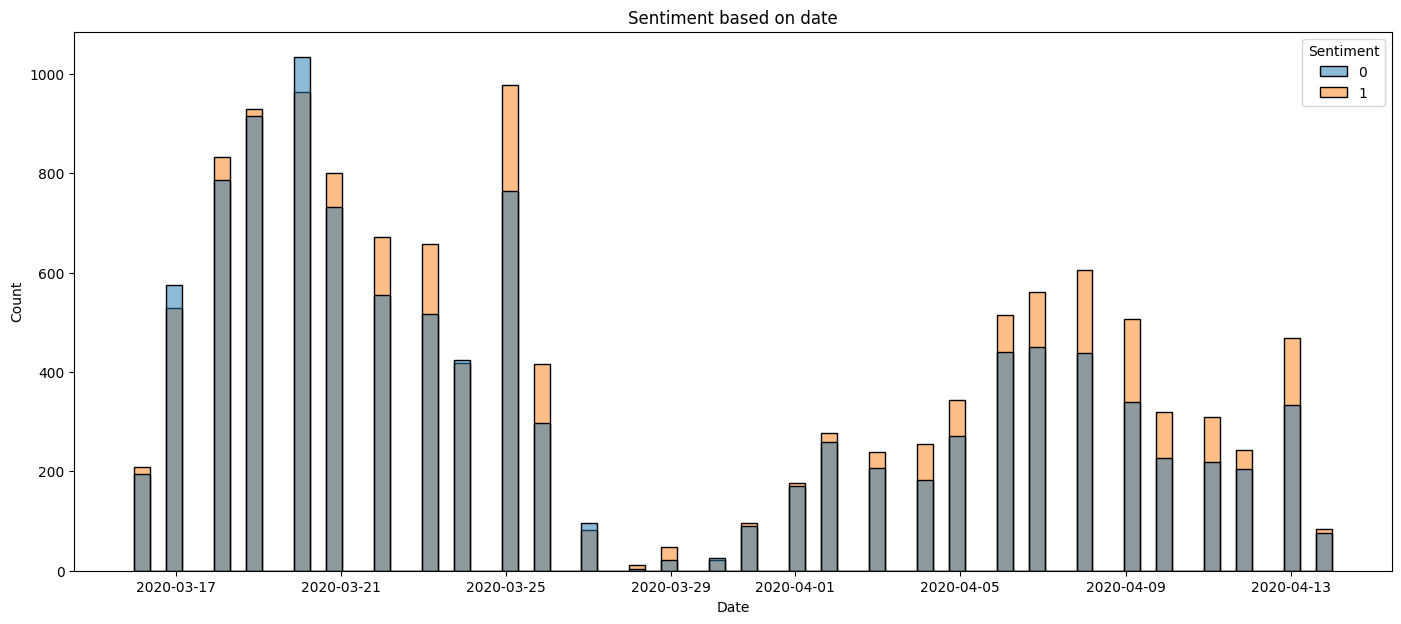

In [ ]:
plt.figure(figsize=(17, 7))
sns.histplot(x="TweetAt", data=X_y_date, hue="Sentiment", bins=75)
plt.xlabel('Date')
plt.ylabel('Count')
plt.title('Sentiment based on date')
plt.show()

**Ответ:** как и в случае с предыдущими признаками, его полезность минимальна..



Поработайте с признаком Location в обучающей выборке. Сколько уникальных значений?

In [ ]:
len(X_train['Location'].value_counts()) #количество оригинальных категорий

7949

Постройте гистограмму топ-10 по популярности местоположений (исключая Unknown)

In [ ]:
popular_location = pd.DataFrame(X_train['Location'].value_counts()[1:11])
popular_location

,count
Location,
London,301
United States,295
"London, England",274
"New York, NY",223
"Washington, DC",222
United Kingdom,204
"Los Angeles, CA",154
India,153
UK,133


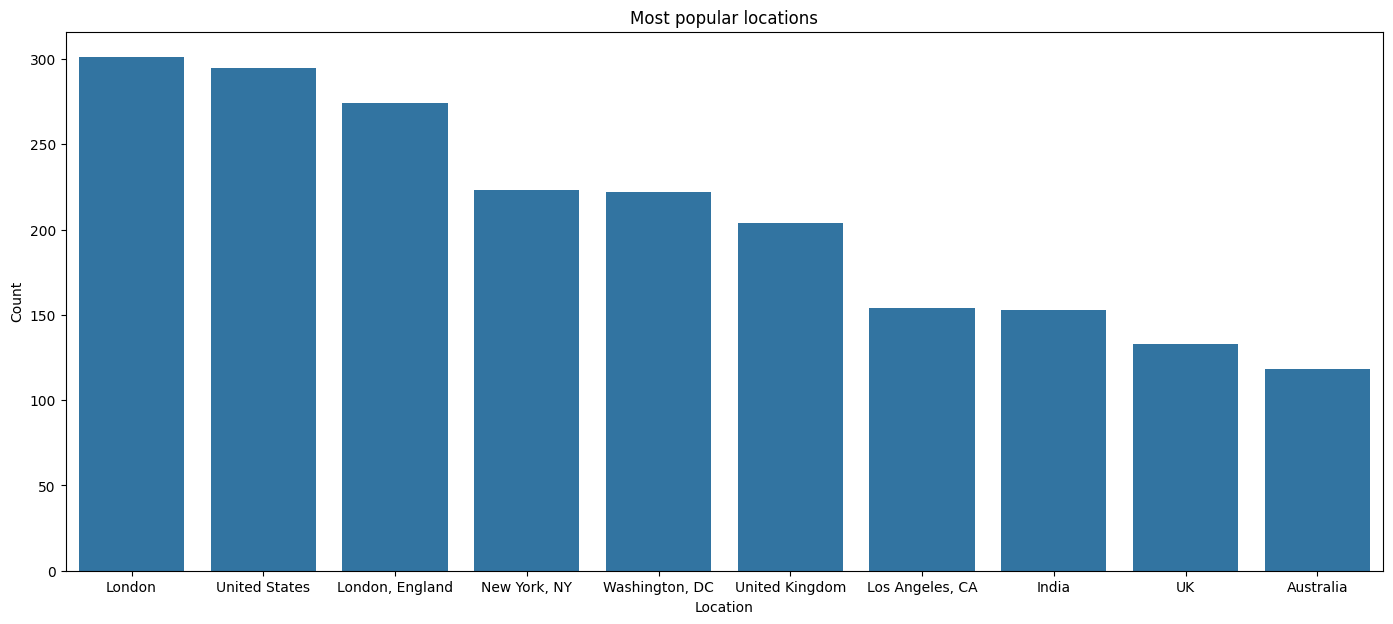

In [ ]:
plt.figure(figsize=(17, 7))
sns.barplot(x="Location", y='count', data=popular_location)
plt.xlabel('Location')
plt.ylabel('Count')
plt.title('Most popular locations')
plt.show()

Видно, что многие местоположения включают в себя более точное название места, чем другие (Например, у некоторых стоит London, UK; а у некоторых просто UK или United Kingdom).

Создайте новый признак WiderLocation, который содержит самое широкое местоположение (например, из London, UK должно получиться UK). Сколько уникальных категорий теперь? Постройте аналогичную гистограмму.

In [ ]:
X_train['WiderLocation'] = X_train['Location'].copy()
X_train['WiderLocation'] = X_train['WiderLocation'].apply(lambda x: x.split(', ')[-1])

In [ ]:
len(X_train['WiderLocation'].value_counts()) #количество оригинальных категорий уменьшилось в два раза

4921

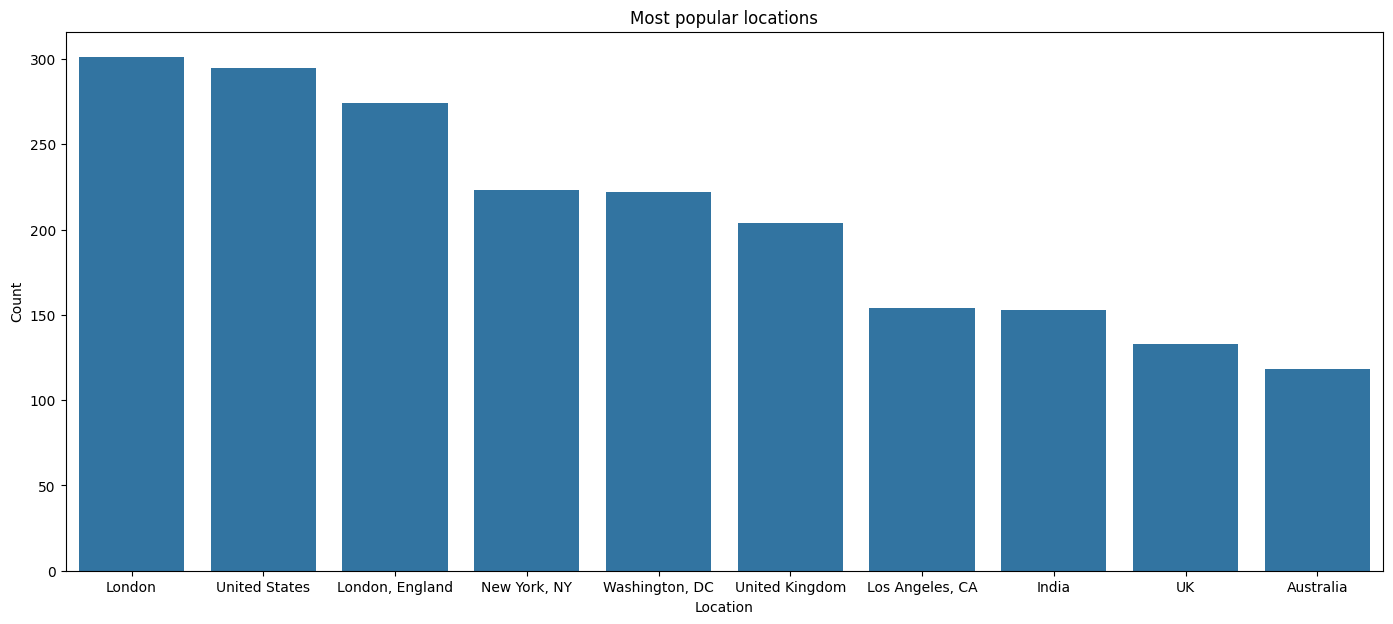

In [ ]:
popular_location2 = pd.DataFrame(X_train['WiderLocation'].value_counts()[1:11])

plt.figure(figsize=(17, 7))
sns.barplot(x="Location", y='count', data=popular_location)
plt.xlabel('Location')
plt.ylabel('Count')
plt.title('Most popular locations')
plt.show()

Закодируйте признак WiderLocation с помощью OHE таким образом, чтобы создались только столбцы для местоположений, которые встречаются более одного раза. Сколько таких значений?


In [ ]:
locations = dict(X_train['WiderLocation'].value_counts())

In [ ]:
X_y_train = pd.concat([X_train, y_train], axis=1) #делаю это для того, чтобы потом размер были совестимы

In [ ]:
X_y_train['Count'] = X_y_train['WiderLocation'].apply(lambda x: locations[x])
X_train_2 = X_y_train[X_y_train['Count'] > 1]

In [ ]:
len(X_train_2['WiderLocation'].value_counts()) #количество значений сократилось

1010

In [ ]:
from sklearn.preprocessing import OneHotEncoder

In [ ]:
ohe = OneHotEncoder(categories='auto', sparse=False)
location_feat = ohe.fit_transform(X_train_2['WiderLocation'].values.reshape(-1, 1))

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Добавьте этот признак к матрице отскалированных текстовых признаков, обучите логистическую регрессию, замерьте качество. Как оно изменилось? Оказался ли признак полезным?


*Подсказка:* используйте параметр `categories` в энкодере.

In [ ]:
X_res_train = pd.merge(pd.DataFrame(lg_scaler.predict(scaler_train)), pd.DataFrame(location_feat), left_index=True, right_index=True, how='inner')

In [ ]:
lg_scaler_dum = LogisticRegression(max_iter=200, random_state=42)
X_res_train.columns = X_res_train.columns.astype(str)
lg_scaler_dum.fit(X_res_train, X_train_2['Sentiment'])

LogisticRegression(max_iter=200, random_state=42)

In [ ]:
print(classification_report(y_train, lg_scaler.predict(scaler_train))) # accuracy - 0.94

              precision    recall  f1-score   support

           0       0.94      0.94      0.94     10846
           1       0.95      0.95      0.95     12564

    accuracy                           0.94     23410
   macro avg       0.94      0.94      0.94     23410
weighted avg       0.94      0.94      0.94     23410



А теперь то же самое, только на тестовой выборке (но мы уже видим, что качество упало..)

In [ ]:
X_test['WiderLocation'] = X_test['Location'].copy()
X_test['WiderLocation'] = X_test['WiderLocation'].apply(lambda x: x.split(', ')[-1])
X_y_test = pd.concat([X_test, y_test], axis=1)

In [ ]:
locations_test = dict(X_test['WiderLocation'].value_counts())
X_y_test['Count'] = X_y_test['WiderLocation'].apply(lambda x: locations_test[x])
X_test_2 = X_y_test[X_y_test['Count'] > 1]

location_feat_test = ohe.fit_transform(X_test_2['WiderLocation'].values.reshape(-1, 1))

X_res_test = pd.merge(pd.DataFrame(lg_scaler.predict(scaler_test)), pd.DataFrame(location_feat_test), left_index=True, right_index=True, how='inner')
X_res_test.columns = X_res_test.columns.astype(str)
print(classification_report(y_test, lg_scaler.predict(scaler_test))) # accuracy - 0.84

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


              precision    recall  f1-score   support

           0       0.83      0.82      0.83      4552
           1       0.85      0.86      0.86      5482

    accuracy                           0.84     10034
   macro avg       0.84      0.84      0.84     10034
weighted avg       0.84      0.84      0.84     10034



**Ответ:** локация не только никак не помогла улучшить качество работы модели, но и ухудшила его, а потому можно сказать, что единственный признак, который имеет значение - OriginalTweet, а WiderLocation не принес особой пользы. Лучше всего работал CountVectorizer со стеммингом (78 чанк) и CountVectoizer с токенизацией custom_tokenizer (65 чанк).

## Задание 8 Хорошее качество (Бонус 1 балл)

Добейтесь accuracy=0.9 на тестовой выборке (можно сменить токенайзер, векторайзер, модель и т.д.)

In [ ]:
# -- YOUR CODE HERE --